# This notebook briefly shows how to deal with images and WCS
Most of the things were discussed in the lecture, so please refer to slides and recording to better understand what's going on. Anyway, to work with astro images in python we need first import required modules

In [2]:
import astropy.io.fits as pyfits
import astropy.wcs
import aplpy
from pylab import *

open the file, print fits header and display content of the first extension

[('SIMPLE', True), ('BITPIX', -32), ('NAXIS', 2), ('NAXIS1', 128), ('NAXIS2', 128), ('COMMENT', "  FITS (Flexible Image Transport System) format is defined in 'Astronomy"), ('COMMENT', "  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H"), ('COMMENT', 'Adaptive-filter smoothed count-rate image for XMM'), ('CONTENT', 'IMAGE'), ('TELESCOP', 'XMM'), ('INSTRUME', 'EPIC'), ('OBS_MODE', 'POINTING'), ('RADECSYS', 'FK5'), ('EQUINOX', 2000), ('BZERO', 0.0), ('BSCALE', 1.0), ('BUNIT', 'c/s/deg2'), ('CRPIX1', 64.5), ('CTYPE1', 'RA---TAN'), ('CRVAL1', 262.6734), ('CDELT1', -0.001), ('CUNIT1', 'deg'), ('CRPIX2', 64.5), ('CTYPE2', 'DEC--TAN'), ('CRVAL2', -21.4933), ('CDELT2', 0.001), ('CUNIT2', 'deg'), ('COMMENT', 'This file was produced using the XMM-ESAS software written by'), ('COMMENT', 'S. L. Snowden, and written using the FITSIO package of'), ('COMMENT', 'W. D. Pence.')]


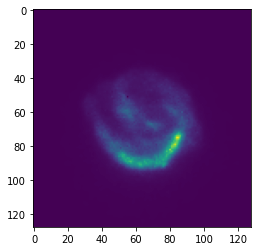

In [3]:
hdu = pyfits.open('adapt-1000-2000.fits')
print([x for x in hdu[0].header.items()])
imshow(hdu[0].data)

now read WCS information from header

In [4]:
wcs = astropy.wcs.WCS(hdu[0].header)
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 262.6734  -21.4933  
CRPIX : 64.5  64.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.001  0.001  
NAXIS : 128  128


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


this object can now be used to convert to/from detector/sky coordinates. For instance, let's find coordinates of the center of the image

In [5]:
x0,y0 = array(shape(hdu[0].data))/2.
print("Ra/dec of the image center at",wcs.all_pix2world(x0,y0,0))

Ra/dec of the image center at [array(262.67286263), array(-21.4928)]


Note that this ~corresponds to CRVAL keyword, which is exactly where coordinates of the image center are. To be more precise, these correspond to pixel coordinates given by CRPIX keyword. Similarly, CDELT gives dimension of a pixel in degrees. Other keywords are specified in WCS standard for more complex conversions. Obviously, you can calculate RA/DEC for any x,y, which can be useful to plot image in world coordinates:

<ipython-input-6-fc6949022aeb>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(RA,DEC,hdu[0].data)


(262.60512445267744,
 262.7416755473226,
 -21.556799973139242,
 -21.429786214878494)

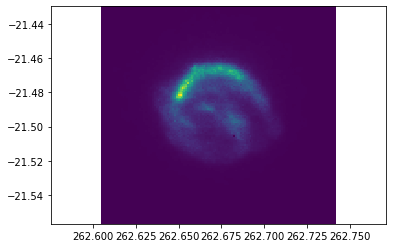

In [6]:
x,y = arange(shape(hdu[0].data)[0]),arange(shape(hdu[0].data)[1])
X,Y = meshgrid(x,y)
RA, DEC = wcs.all_pix2world(X,Y,0)
pcolor(RA,DEC,hdu[0].data)
axis('equal')

Same task may be more conviniently done using aplpy module which also takes care of formatting the labels properly and traditional ordering of RA/DEC. Under the hood it still uses astropy.wcs, however

INFO: Auto-setting vmin to -1.206e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.360e+04 [aplpy.core]


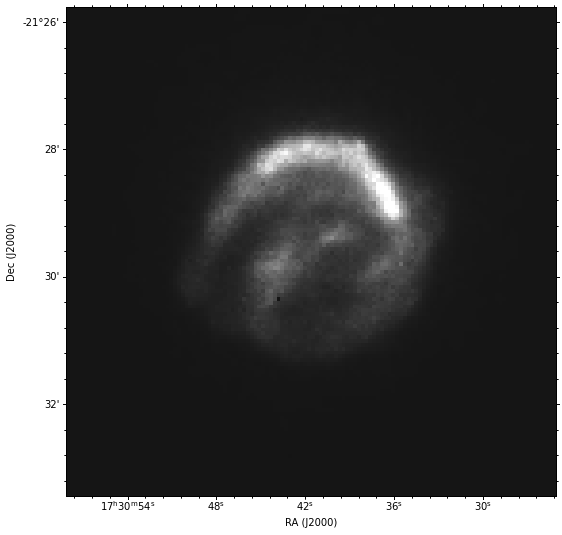

In [7]:
gc = aplpy.FITSFigure(hdu)
gc.show_grayscale()

Considering that we data we have is simply a numpy array we can do a bunch of analyses now. Can plot contours, calculate pixel statistics (for instance total flux from the remnant), and so on. You basically have full access to functionality offered by *numpy* and modules like *scikit.image* (*skimage*). In this particular case it could be interesting, for instance, find geometric center of the shell and make radial profile. To find the center we'll use [*Hough*](https://scikit-image.org/docs/0.8.0/auto_examples/plot_circular_hough_transform.html) transform, and for radial profile numpy functions. But first, we need to make the shell a real shell, otherwise hough will yield nothing meaningful

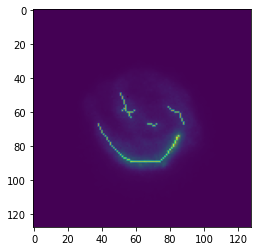

In [8]:
from skimage.transform import hough_circle
from skimage import color
from skimage.feature import peak_local_max
from skimage.draw import circle_perimeter
import skimage.morphology, skimage.filters

image = hdu[0].data # just for convinience
dog = skimage.filters.difference_of_gaussians(image,1,5)
skeleton = skimage.morphology.skeletonize(dog>=0.5*skimage.filters.threshold_li(dog))
imshow(image)
imshow(skeleton,alpha=0.5)

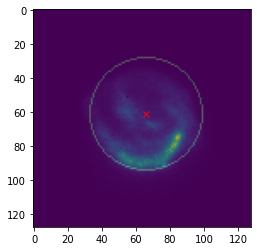

In [9]:
# radius is about 30, so search around this value
hough_radii = [28]
res = hough_circle(skeleton, hough_radii)
ridx, y0, x0 = np.unravel_index(np.argmax(res), res.shape)
mask = zeros_like(image)
mask[skimage.draw.circle_perimeter(y0,x0,33,shape=image.shape)]=1
imshow(image)
imshow(mask,alpha=0.3)
plot([x0],[y0],'rx')

Now we can plot a radial profile. To do that it's also convinient to use skimage.draw functionality. To scale radius in arcminutes we use wcs attribute cdelt. We can also print estimated center and radius of the remnant in wcs coordinates.

SNR center is at 262.671, -21.496 and it has radius of 1.56 arcmin


Text(0, 0.5, 'mean flux')

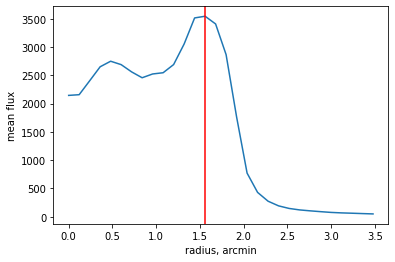

In [10]:
radii = arange(0,60,2)
meanflux = []
for r in radii:
    meanflux.append(mean(image[skimage.draw.circle_perimeter(y0,x0,r,shape=image.shape)]))
px2arcmin = wcs.wcs.cdelt[-1]*60
plot(radii*px2arcmin,meanflux)
r_snr = (radii*px2arcmin)[argmax(meanflux)]
axvline(r_snr,c='r')
ra0,de0 = wcs.all_pix2world(x0,y0,0)
print("SNR center is at %.3f, %.3f and it has radius of %.2f arcmin"%(ra0,de0,r_snr))
xlabel('radius, arcmin')
ylabel('mean flux')
